lasso_without_dist.pkl
Predicted vs labels LASSO without dist


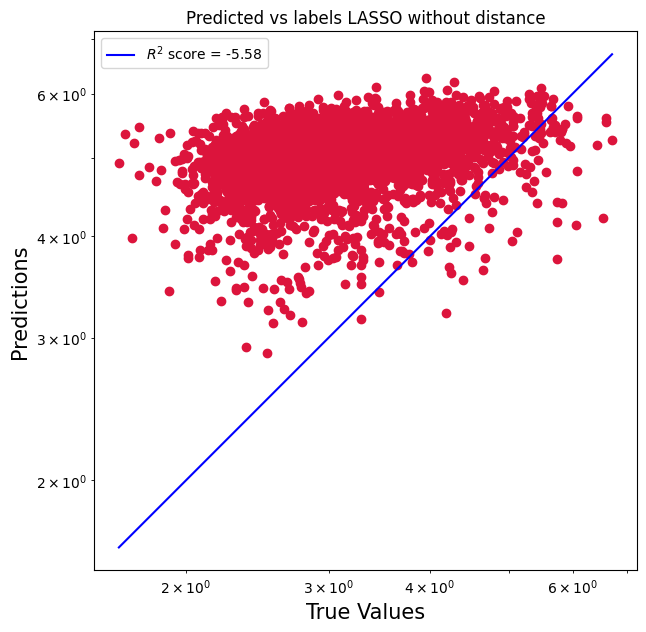

lasso_without_dist_all_distance_metrics_without_pca.pkl
Predicted vs labels LASSO without dist all distance metrics without pca


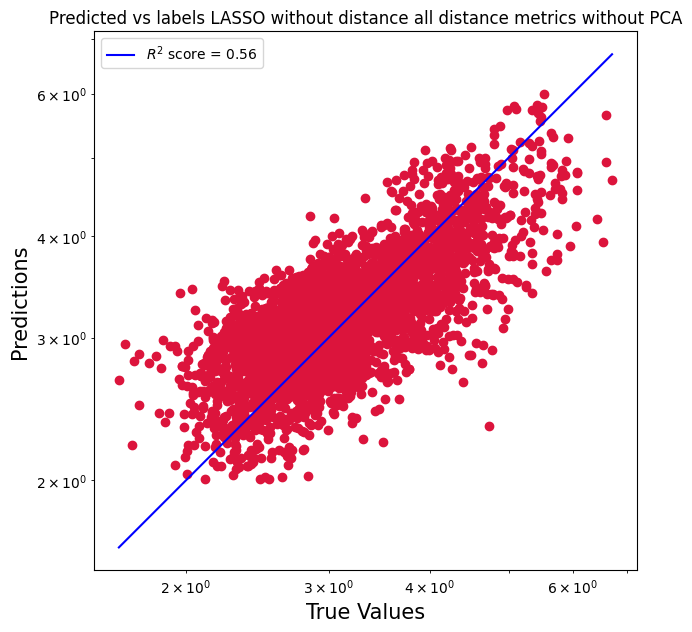

lasso_without_dist_all_distance_metrics_with_pca.pkl
Predicted vs labels LASSO without dist all distance metrics with pca


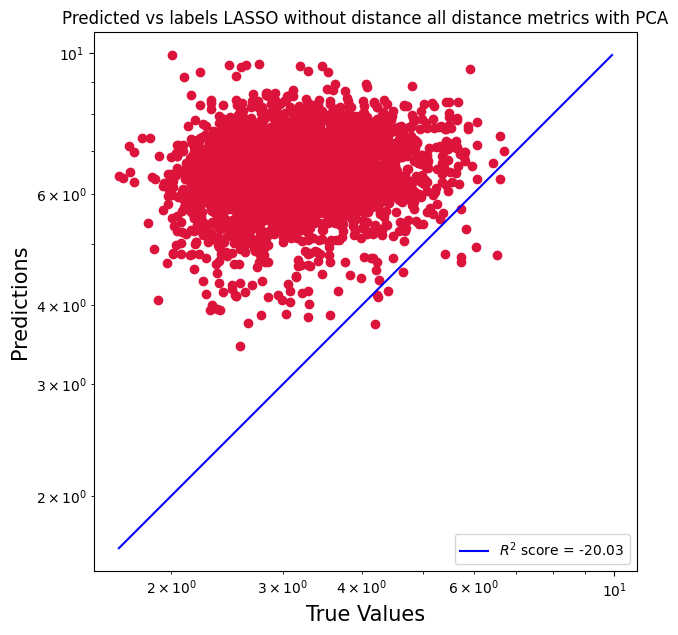

lasso_with_dist.pkl
Predicted vs labels LASSO with dist


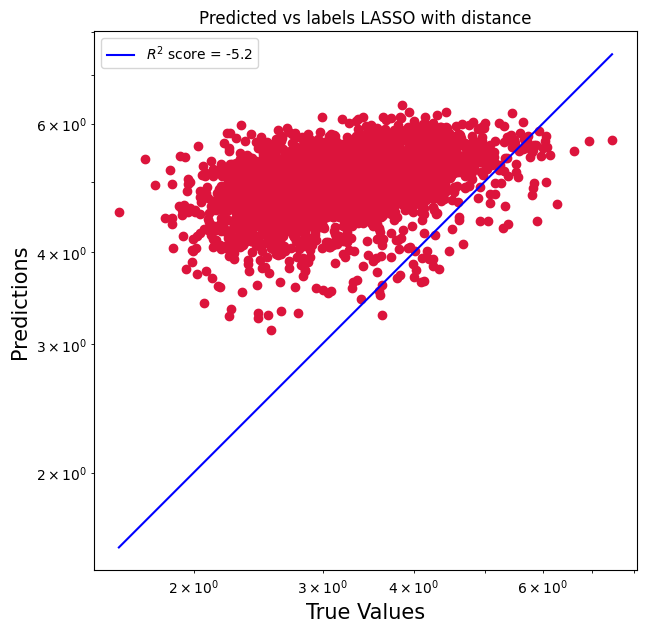

lasso_with_dist_all_distance_metrics_without_pca.pkl
Predicted vs labels LASSO with dist all distance metrics without pca


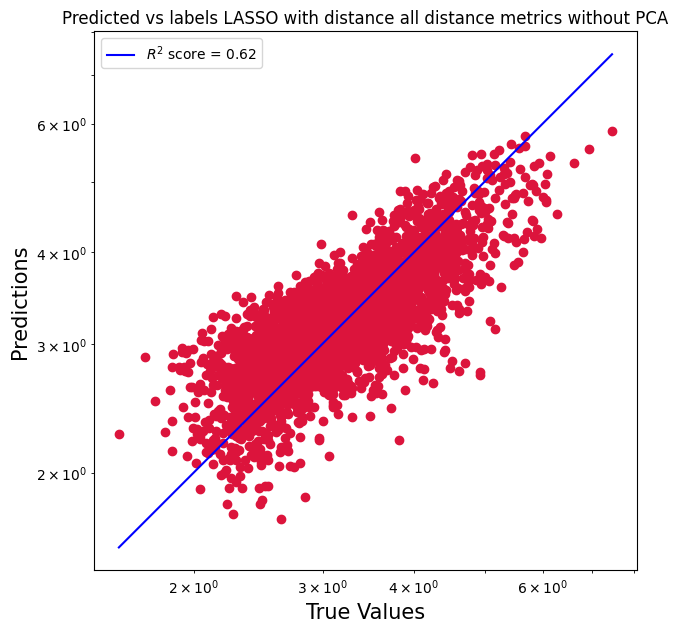

lasso_with_dist_all_distance_metrics_with_pca.pkl
Predicted vs labels LASSO with dist all distance metrics with pca


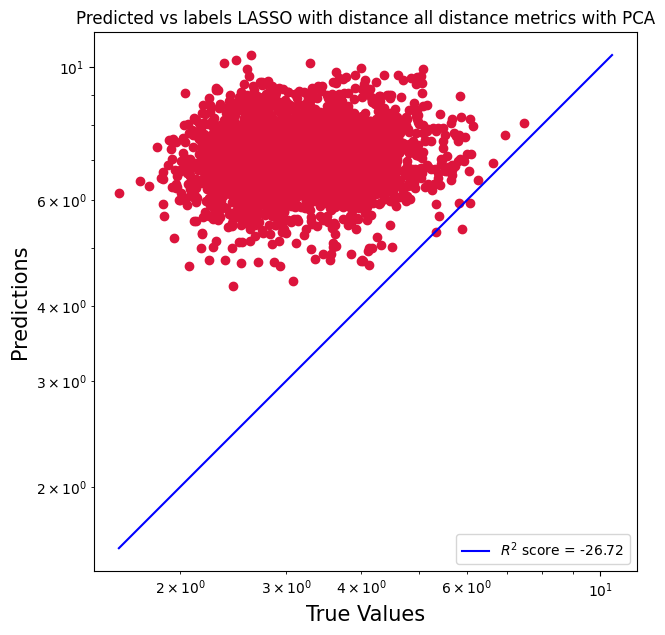

rf_without_dist.pkl
Predicted vs labels Random Forrest without dist


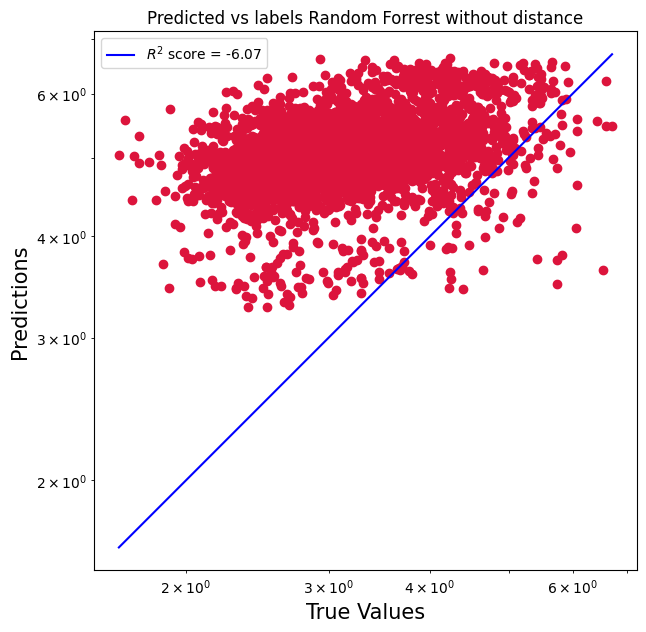

rf_without_dist_all_distance_metrics_without_pca.pkl
Predicted vs labels Random Forrest without dist all distance metrics without pca


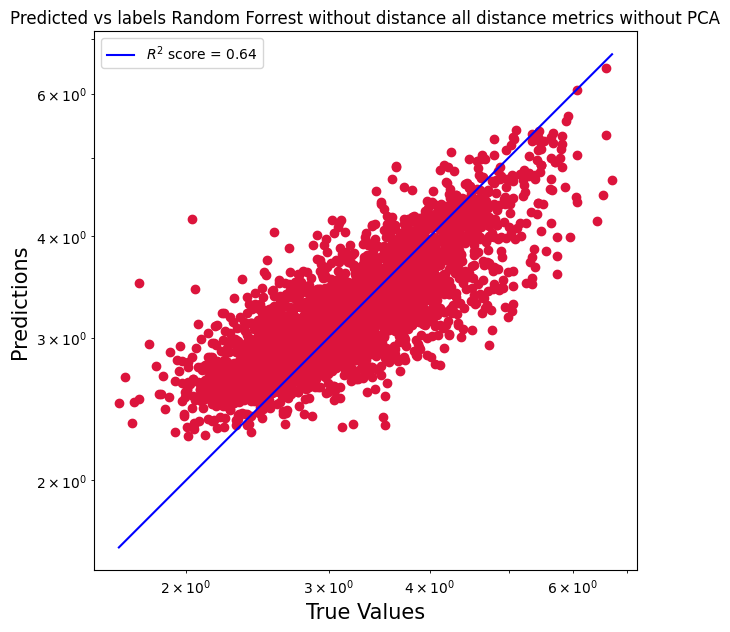

rf_without_dist_all_distance_metrics_with_pca.pkl
Predicted vs labels Random Forrest without dist all distance metrics with pca


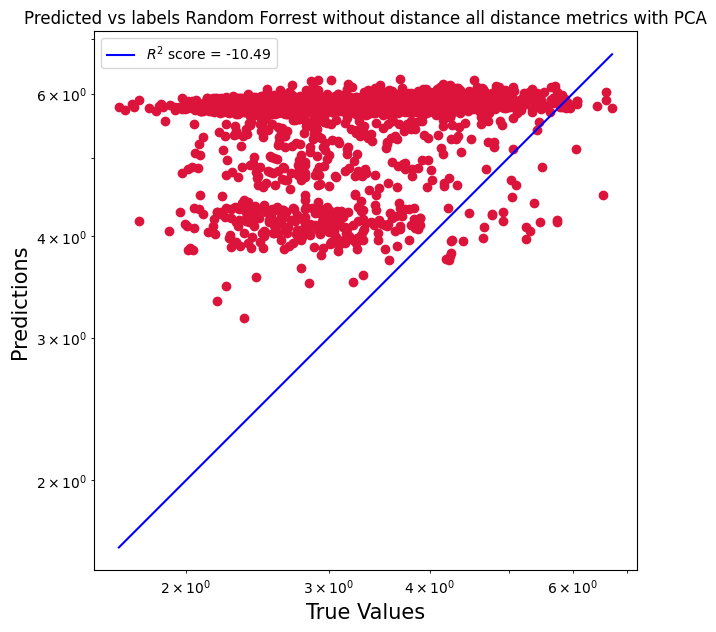

rf_with_dist.pkl
Predicted vs labels Random Forrest with dist


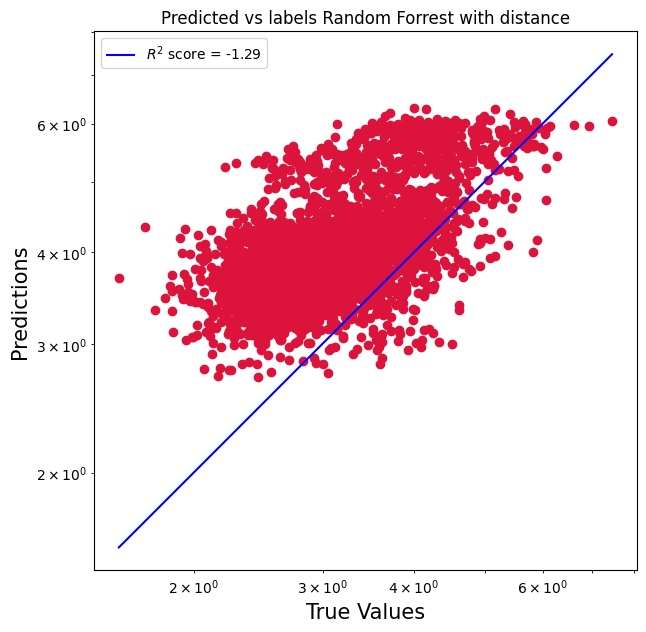

rf_with_dist_all_distance_metrics_without_pca.pkl
Predicted vs labels Random Forrest with dist all distance metrics without pca


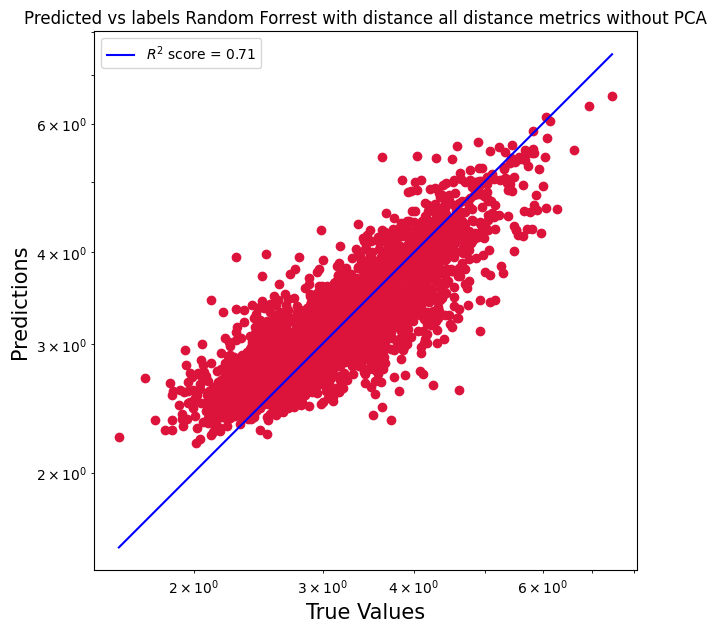

rf_with_dist_all_distance_metrics_with_pca.pkl
Predicted vs labels Random Forrest with dist all distance metrics with pca


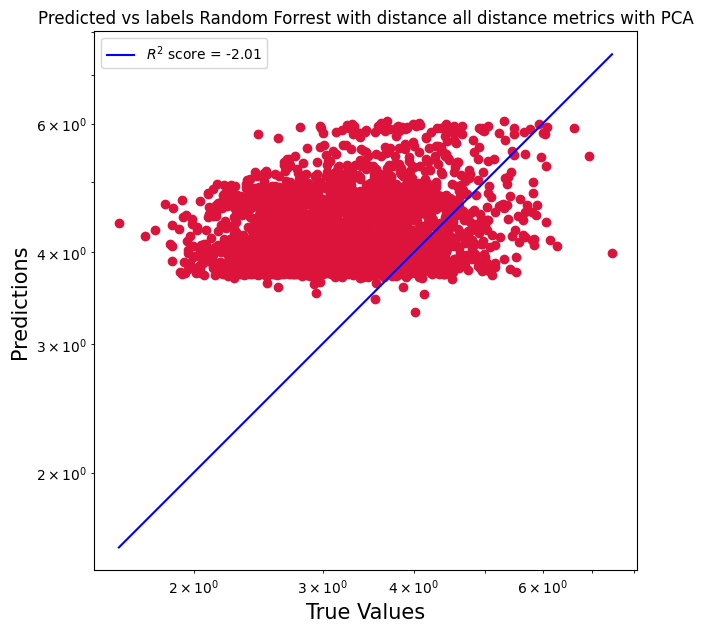

In [1]:
from src.drivers.plots.plot_all_pred_vs_label import run
run()

In [8]:
#from src.drivers.train_models.all_distance_metrics_without_pca import run 
#run()